# Guide

This is simply guide for excuting this repository. Also contain reqired processing step.

## 0. Make Environment

This fork version is setted as custom data should be located at `Computer_Vision_Project/Dataset` folder.
So unzip original dataset file, and locate this place. And rename the origianl `train.json` file to `old_train.json`. This file is needed to generate new training configs.

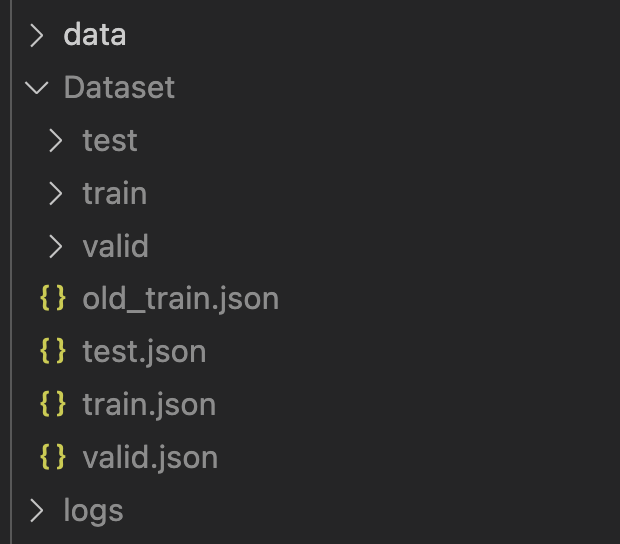

This repository use `poetry`, which is a python package manager.  
To setup python environment process is explained in deatail at `README.md`.  
After that, excute below cells.

## 1. Import config file

In [58]:
import json

path = "Dataset/train_augmented.json"
config = json.load(open(path))

### Simple information

Config json has `images` and `annotations` keys.  
Each `images` elements has `id`, `width`, `height` and `file_name` keys.  
Each `annotations` elements has `id`, `image_id`, `category_id`, `segmentation`, `area`, `bbox` and `iscrowd`.  
`id` and `image_id` labels are the same in this file, and `iscrowd` is not used.  
`bbox` annotation contains 4 numbers, which is (`left_upper_x`, `left_upper_y`, `bbox_width`, `bbox_height`).

Whole dataset have 4 scenery. Each scenery is divided by iamge number. For 0~123, 124~236, 237~331, 332~457.  
Also, 6, 21, 35, 41, 74 is weired train image.

In [59]:
annotated_idx = []
for ele in config["annotations"]:
    annotated_idx.append(ele["image_id"])
    
# number of images for whole dataset
print(len(set(annotated_idx)))

# number of images for each sceneries
categories = {x:[] for x in range(4)}
for num in set(annotated_idx):
    if num < 124 and num not in [6, 21, 35, 41, 74]:
        categories[0].append(num)
    elif num < 237:
        categories[1].append(num)
    elif num < 332:
        categories[2].append(num)
    else:
        categories[3].append(num)

for cat in categories:
    print(len(categories[cat]))
# 6 6 5 6

447
58
60
47
282


In [42]:
# extract random number for valid
import random
random.seed(0)
valid_idx = []

# extract about 10% images for each sceneries
valid_idx += random.sample(categories[0], 6)
valid_idx += random.sample(categories[1], 6)
valid_idx += random.sample(categories[1], 5)
valid_idx += random.sample(categories[1], 6)

len(valid_idx)

23

In [43]:
# iamges size, all the same
set([(ele["height"], ele["width"]) for ele in config["images"]])

{(345, 640)}

### Make new train/valid config

In [ ]:
import matplotlib.pyplot as plt
import cv2

train = {"images": [], "annotations": [], "classes": [x for x in range(15)]}
for idx in set(annotated_idx):
    #print(config["images"])
    train["images"].append(config["images"][idx])
    # img = cv2.imread("Dataset/" + config["images"][idx]["file_name"])
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # break
    
for ann in config["annotations"]:
    if ann["image_id"] in set(annotated_idx):
        new_ann = ann.copy()
        new_ann["category_id"] = ann["category_id"] - 1
        x, y, w, h = ann["bbox"]
        x /= 640
        y /= 345
        w /= 640
        h /= 345
        new_ann["bbox"] = (x + w/2, y + h/2, w, h)
        train["annotations"].append(new_ann)
        # cv2.rectangle(img, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2)
        # plt.imshow(img)
    # break

with open("Dataset/train.json", "w") as f:
    json.dump(train, f)

In [45]:
valid = {"images": [], "annotations": [], "classes": [x for x in range(15)]}
print(valid_idx)
for idx in valid_idx:
    valid["images"].append(config["images"][idx])
for ann in config["annotations"]:
    if ann["image_id"] in valid_idx:
        new_ann = ann.copy()
        new_ann["category_id"] = ann["category_id"] - 1
        x, y, w, h = ann["bbox"]
        x /= 640
        y /= 345
        w /= 640
        h /= 345
        new_ann["bbox"] = (x + w/2, y + h/2, w, h)
        valid["annotations"].append(new_ann)
with open("Dataset/valid.json", "w") as f:
    json.dump(valid, f)
        
len(valid["images"]), len(valid["annotations"])

[58, 26, 52, 28, 2, 17, 152, 151, 145, 170, 173, 139, 150, 142, 157, 177, 178, 133, 152, 128, 138, 177, 168]


(23, 102)

### Plot validation annotations

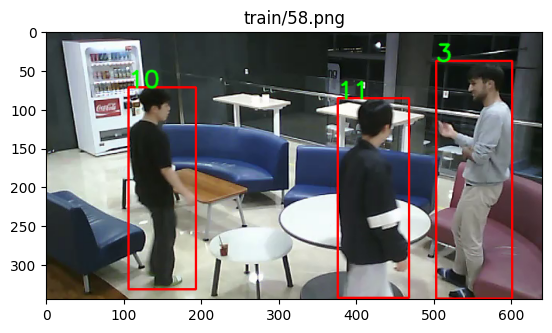

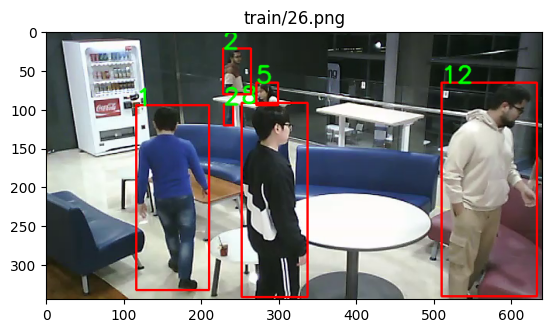

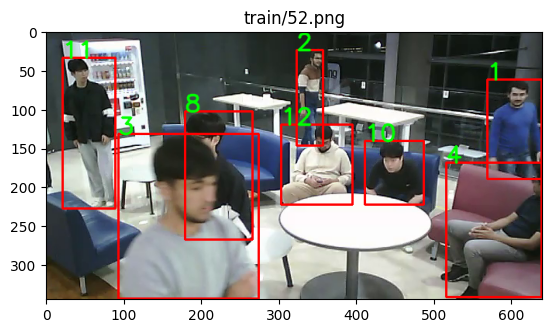

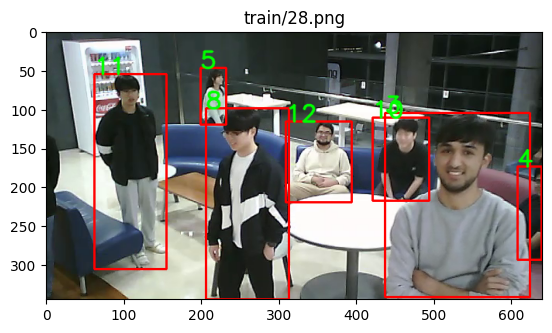

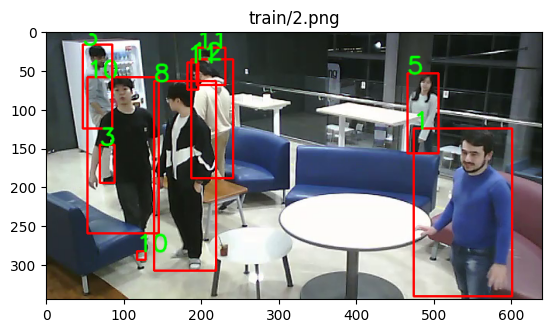

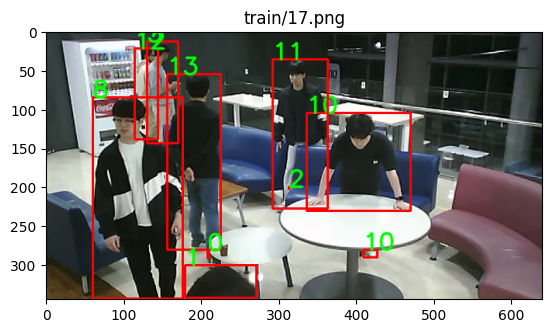

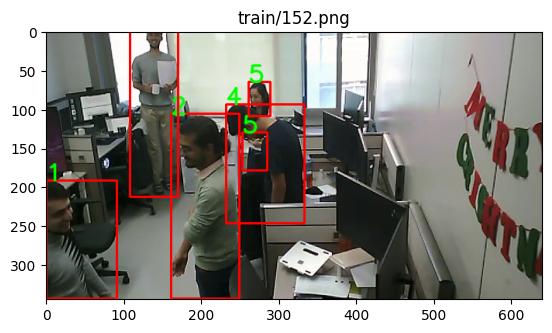

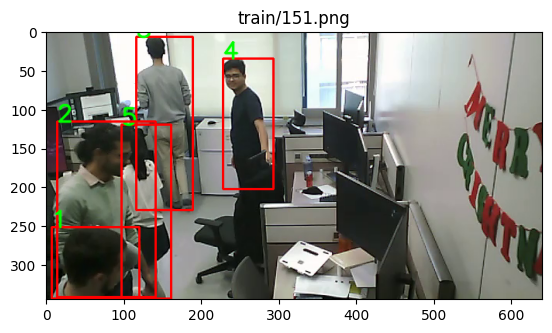

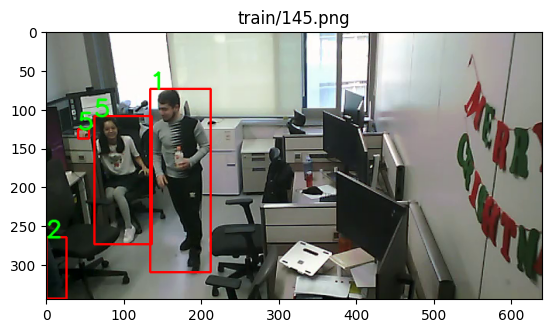

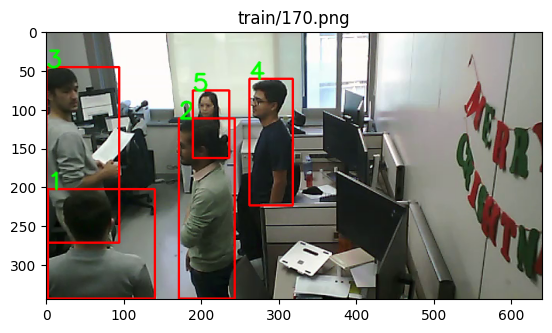

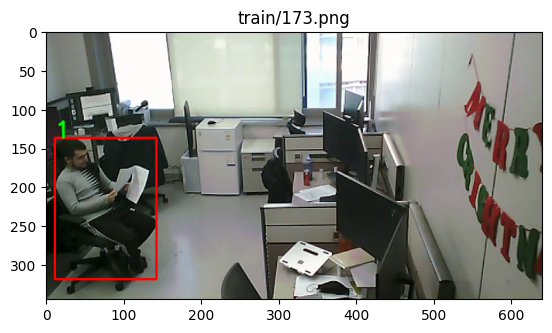

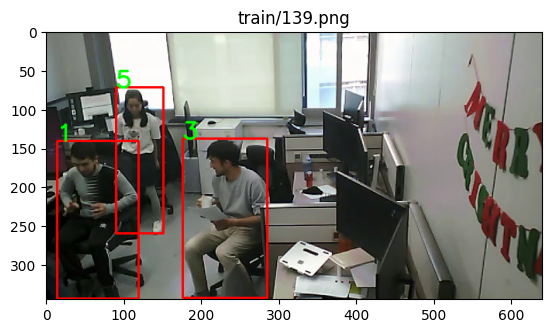

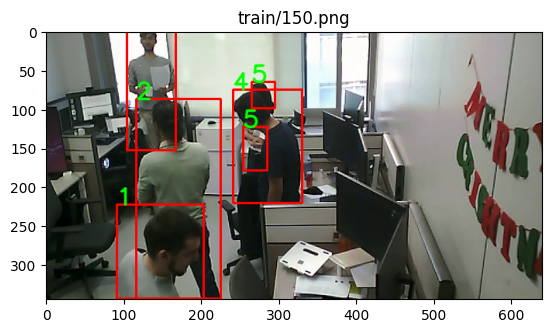

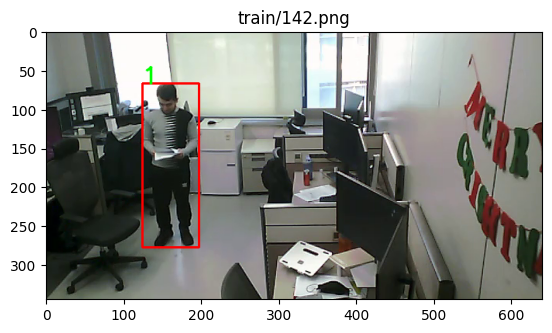

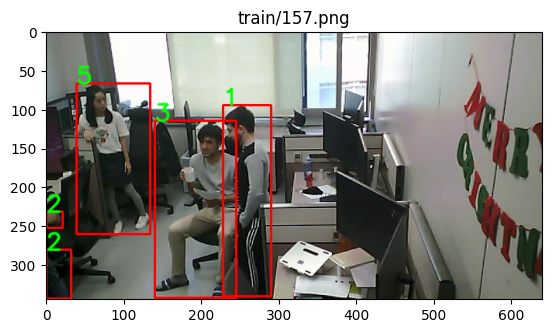

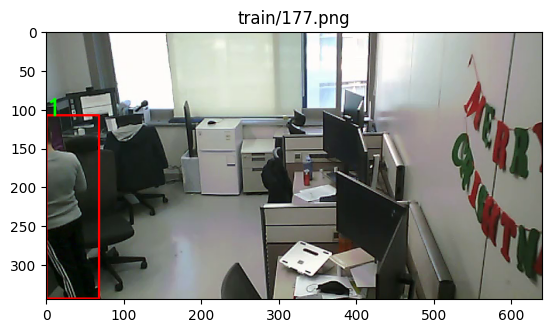

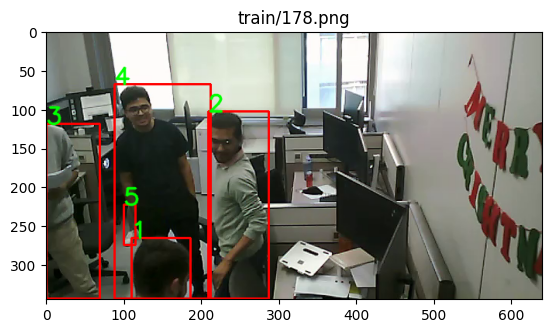

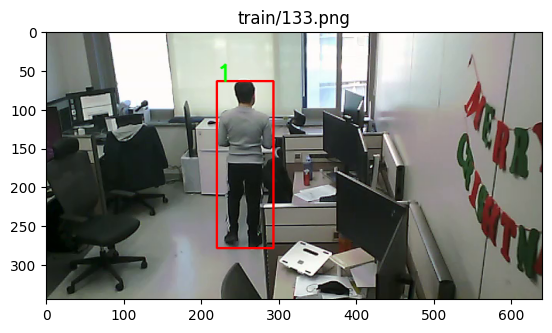

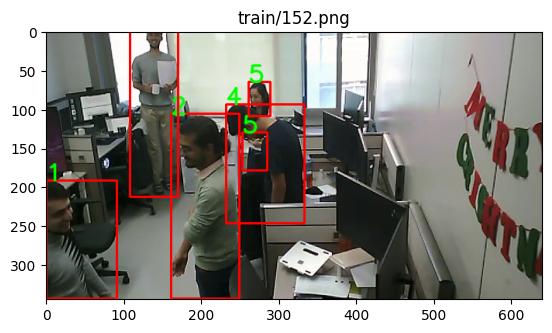

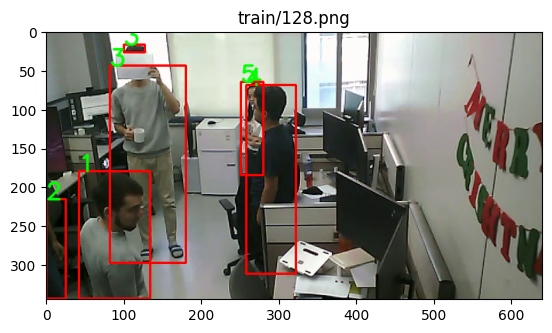

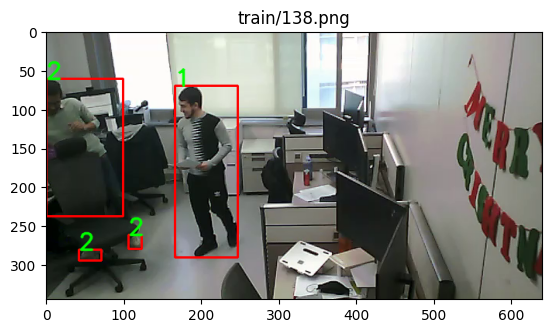

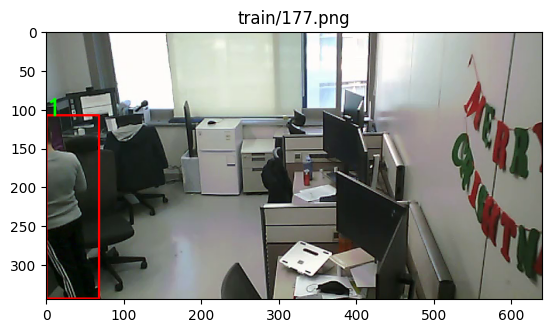

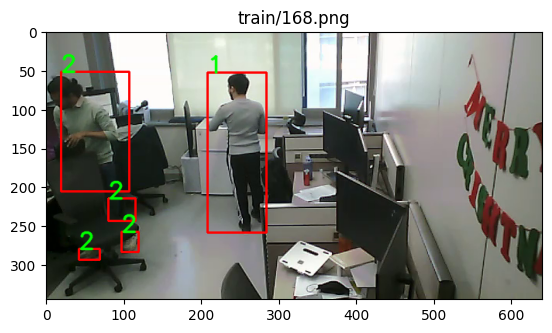

In [46]:
for ele in valid["images"]:
    img = cv2.imread("Dataset/" + ele["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    id = ele["id"]
    for ann in train["annotations"]:
        if ann["image_id"] == id:
            c = ann["category_id"]+1
            x, y, w, h = ann["bbox"]
            x -= w/2
            y -= h/2
            x *= 640
            y *= 345
            w *= 640
            h *= 345
            cv2.rectangle(img, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2)
            cv2.putText(img, str(c), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    plt.imshow(img)
    plt.title(ele["file_name"])
    plt.show()

After make new configs, than you can start training. Here's my training commands, and this requires `darknet53.conv.74` pretrained weight file.  
Download pretrained weight is explained in `README.md`

* Training command 
    ```
    poetry run yolo-train --epochs 500 --model config/yolov3-custom.cfg --train Dataset/train.json --valid Dataset/valid.json --pretrained weights/darknet53.conv.74
    ```
* Inference by bbox images
    ```
    poetry run yolo-detect --model config/yolov3-custom.cfg --weights checkpoints/yolov3_ckpt_{your_version}.pth --config Dataset/valid.json
    ```

* Print detailed metrics
    ```
    poetry run yolo-test --model config/yolov3-custom.cfg --weights checkpoints/yolov3_ckpt_{your_version}.pth --config Dataset/valid.json
    ```
* Generate submit json file
    * This code was hasten, you need manually change `load_model` part with yout trained `.pth` file path.
    ```
    python infer.py
    ```

## A. Plot infer result

(345, 640, 3)


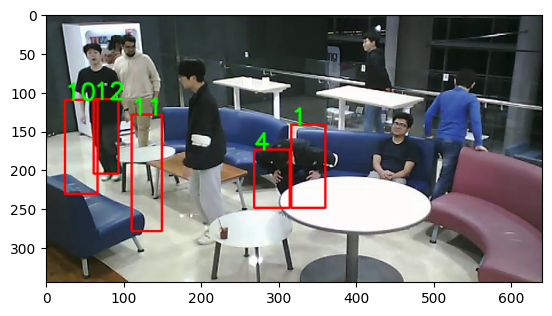

In [57]:
import json
from PIL import Image
import matplotlib.pyplot as plt
import cv2

with open("pred.json", "r") as f:
    data = json.load(f)

idx = 2000
img = cv2.cvtColor(cv2.imread(f"Dataset/test/{idx}.png"), cv2.COLOR_BGR2RGB)
print(img.shape)
for ele in data:
    if ele["image_id"] == idx:
        x, y, w, h = ele["bbox"]
        img = cv2.rectangle(img, (int(x), int(y)), (int(x+w), int(y+h)), (255, 0, 0), 2)
        cv2.putText(img, str(ele["category_id"]), (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

plt.imshow(img)

In [ ]:
from tqdm import tqdm
import numpy as np

import torch
import zipfile

from pytorchyolo.models import load_model
from pytorchyolo.utils.utils import non_max_suppression, rescale_boxes
from pytorchyolo.detect import _create_data_loader
import json
from pathlib import Path

images = sorted([str(x) for x in Path("Dataset/test").rglob("*.png")])
dataloader = _create_data_loader(images, 1, 416, 8)
model = load_model("config/yolov3-custom.cfg", "checkpoints/yolov3_ckpt_265.pth").cuda()
model.eval()

pred = []
conf_thres = 0.5
# conf_thres = 0.001
nms_thres = 0.4

for (img_paths, input_imgs) in tqdm(dataloader, desc="Detecting"):
    name = img_paths[0].split("/")[-1].split(".")[0]
    #print(name)
    # Get detections
    with torch.no_grad():
        detections = model(input_imgs.cuda())
        detections = non_max_suppression(detections, conf_thres, nms_thres)
        # break
        plot_img = input_imgs[0].permute(1, 2, 0).numpy()
        h, w = (345, 640)
        # detections = rescale_boxes(detections[0], 416, (h, w))
        for x1, y1, x2, y2, conf, cls_pred in detections[0]:
            x1, y1, x2, y2, conf, cls_pred = map(lambda x:x.item(), [x1, y1, x2, y2, conf, cls_pred])
            x1, y1, x2, y2 = map(lambda x: 0 if x < 0 else x, [x1, y1, x2, y2])
            y1, y2 = map(lambda y: h if y > h else y, [y1, y2])
            x1, x2 = map(lambda x: w if x > w else x, [x1, x2])
            #print(x1, y1, x2, y2)
            plot_img = cv2.rectangle(plot_img.copy(), (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
            #plt.imshow(plot_img)
            # break
            pred.append({
                        "image_id": int(name),
                        "category_id": int(cls_pred)+1,
                        "bbox": list(map(lambda x:float(f"{x:.3f}"), [x1, y1, x2-x1, y2-y1])),
                        "score": float(f"{conf:.5f}"),
                    })

# Save the list of predictions as a JSON file
with open("pred.json", "w") as f:
    json.dump(pred, f)

# Create a ZIP file and add the JSON file to it
zip_file = zipfile.ZipFile("predictions.zip", "w")
zip_file.write("pred.json")
zip_file.close()